# Multitemporal data analysis and CLMS data download via Sentinel Hub APIs

This notebook demonstrates how to visualize Leaf Area Index (LAI) data for Latvia using the Sentinel Hub APIs in the Copernicus Data Space Ecosystem. We'll use the LAI 300m 10-daily V1 RT6 data collection to analyze vegetation coverage across Latvia.

The Leaf Area Index is defined as half the total area of green elements of the canopy per unit horizontal ground area. This is a crucial parameter for monitoring vegetation health, agricultural productivity, and ecosystem changes.

## Import Required Libraries

We'll start by importing the necessary libraries for data processing, visualization, and accessing Sentinel Hub APIs.

In [3]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as cx
import getpass
import datetime
import numpy as np

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubDownloadClient,
    CRS,
    MimeType,
    Geometry,
)

from utils import plot_image

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [2]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
#config.save("cdse")

In [4]:
# If you have already configured a profile, uncomment and specify your profile name
config = SHConfig("cdse")

## Load Latvia Geometry

We'll load the geographical boundaries of Latvia from the Natural Earth countries dataset and visualize the area of interest. This provides us with accurate, standardized country boundaries.

/var/folders/7p/dpt81n653g7cm1ny5rm0_6q80000gn/T/ipykernel_50391/2874767396.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latvia_gdf["area"] = latvia_gdf.geometry.area


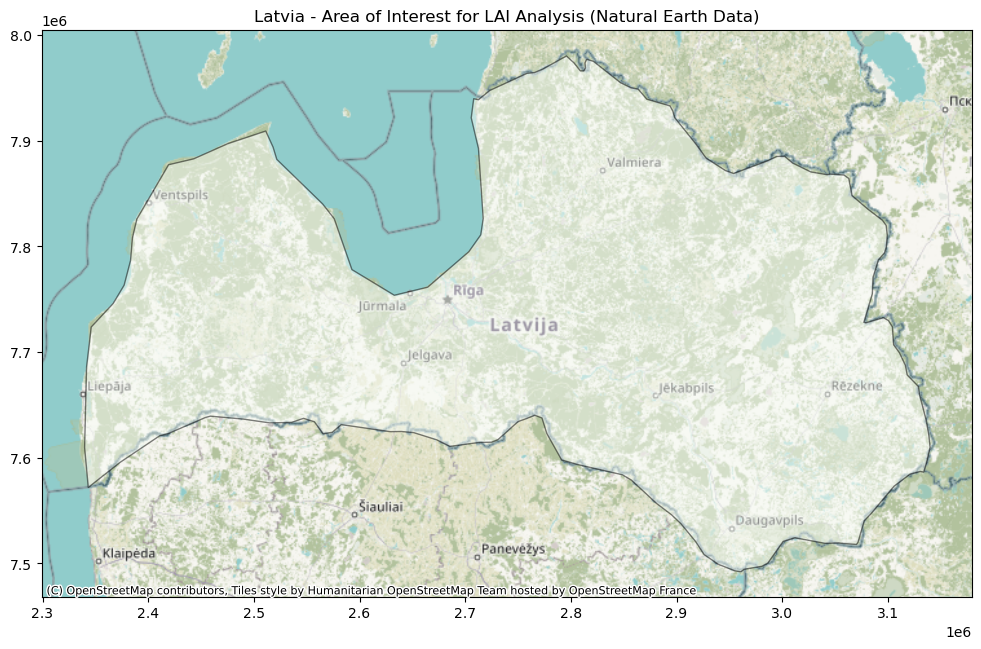

Latvia Information (from Natural Earth dataset):
- Area: 64,554 km²
- Area (degrees): 9.504812 square degrees
- Bounding box: (21.01, 55.67) to (28.20, 58.06)
- Country name: Latvia
- ISO A3 code: LVA


In [5]:
# Load Latvia boundaries from Natural Earth countries dataset
countries_path = "data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
countries = gpd.read_file(countries_path)

# Filter for Latvia from the Natural Earth dataset
latvia_gdf = countries[countries['NAME'] == 'Latvia'].copy()

if latvia_gdf.empty:
    print("Latvia not found in the Natural Earth dataset. Available countries:")
    print(sorted(countries['NAME'].unique()))
else:
    # Project to a suitable projected coordinate system for area calculation (ETRS89 / Latvia TM)
    latvia_gdf_utm = latvia_gdf.to_crs(epsg=3059)  # Latvia TM coordinate system
    latvia_gdf["area_km2"] = latvia_gdf_utm.geometry.area / 1e6  # Convert from m² to km²
    
    # Keep original area in degrees for compatibility
    latvia_gdf["area"] = latvia_gdf.geometry.area
    
    # Project to Web Mercator for visualization
    latvia_gdf_proj = latvia_gdf.to_crs(epsg=3857)
    
    # Visualize Latvia boundaries
    ax = latvia_gdf_proj.plot(alpha=0.5, cmap="Greens", edgecolor="k", figsize=(12, 8))
    cx.add_basemap(ax)
    plt.title("Latvia - Area of Interest for LAI Analysis (Natural Earth Data)")
    plt.show()
    
    # Print information about Latvia
    bounds = latvia_gdf.geometry.iloc[0].bounds
    print(f"Latvia Information (from Natural Earth dataset):")
    print(f"- Area: {latvia_gdf['area_km2'].iloc[0]:,.0f} km²")
    print(f"- Area (degrees): {latvia_gdf['area'].iloc[0]:.6f} square degrees")
    print(f"- Bounding box: ({bounds[0]:.2f}, {bounds[1]:.2f}) to ({bounds[2]:.2f}, {bounds[3]:.2f})")
    print(f"- Country name: {latvia_gdf['NAME'].iloc[0]}")
    print(f"- ISO A3 code: {latvia_gdf['ISO_A3'].iloc[0] if 'ISO_A3' in latvia_gdf.columns else 'N/A'}")

## Define NPP Evalscript

This evalscript will process the LAI (Leaf Area Index) data from the CLMS dataset. The NPP 300m 10-daily V1 RT6 data collection provides estimates every 10 days at global scale with approximately 300m spatial resolution.

In [33]:
npp_evalscript = """
//VERSION=3
const factor = 1 / 2000; 
const offset = 0; 

function setup() {
  return {
    
    input: ["NPP", "dataMask"],
    output: [
      { id: "default", bands: 4, sampleType: "UINT8" },
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "eobrowserStats", bands: 2, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ],
  };
}

function evaluatePixel(samples) {
  
  var originalValue = samples.NPP;

  let val = originalValue * factor + offset;

  let dataMask = samples.dataMask;

  const indexVal = dataMask === 1 ? val : NaN;
  const imgVals = visualizer.process(val);

  return {
    default: imgVals.concat(dataMask * 255),
    index: [indexVal],
    eobrowserStats: [val, dataMask],
    dataMask: [dataMask],
  };
}


const ColorBar = [
  [0.0, [255, 255, 255]],
  [0.0005, [255, 0, 0]],
  [1.5, [255, 165, 0]],
  [3.0, [255, 215, 0]],
  [4.5, [255, 255, 0]],
  [6.0, [173, 255, 47]],
  [7.5, [20, 255, 20]],
  [9.0, [10, 200, 10]],
  [10.5, [0, 136, 0]],
];
const visualizer = new ColorRampVisualizer(ColorBar);
"""

## Request Net Primary Production (NPP) Data for Latvia

Now we'll create a request to fetch NPP data for Latvia using the Process API. We'll use the NPP 300m 10-daily V1 RT6 data collection (BYOC collection ID: 3a8387bb-edfd-4889-b6d9-44b99829b92d).

In [34]:
# Create geometry for Latvia
geometry = Geometry(geometry=latvia_gdf.geometry.values[0], crs=CRS.WGS84)

# Create the request for NPP data
request = SentinelHubRequest(
    evalscript=npp_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(
                "3a8387bb-edfd-4889-b6d9-44b99829b92d"
            ),
            time_interval=("2024-05-01", "2024-05-10"),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG),
    ],
    geometry=geometry,
    resolution=[0.01, 0.01],
    config=config,
)

print("Request created successfully. Fetching NPP data for Latvia...")

Request created successfully. Fetching LAI data for Latvia...


## Fetch and Visualize NPP Data

Let's fetch the NPP data and create a visualization showing the vegetation coverage across Latvia.

In [35]:
# Get the NPP data
npp_img = request.get_data()

print(f"Returned data is of type = {type(npp_img)} and length {len(npp_img)}.")
print(f"Single element in the list is of type {type(npp_img[0])} and has shape {npp_img[0].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (240, 719, 4)


Image type: uint8


<Figure size 1500x1000 with 0 Axes>

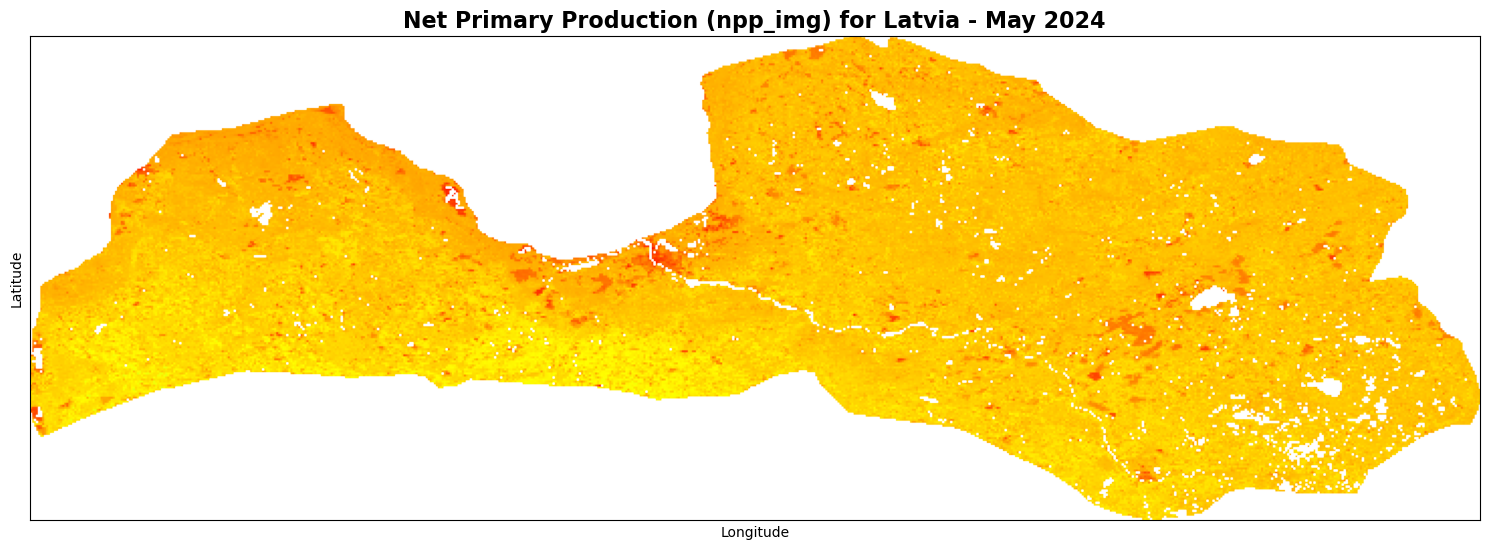

In [36]:
# Visualize the NPP data
image = npp_img[0]
print(f"Image type: {image.dtype}")

# Create the visualization
plt.figure(figsize=(15, 10))
plot_image(image, factor=1/255)
plt.title("Net Primary Production (npp_img) for Latvia - May 2024", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

In [20]:
start = datetime.datetime(2024, 5, 1)
end = datetime.datetime(2024, 9, 30)
n_chunks = 6
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2024-05-01', '2024-05-26')
('2024-05-26', '2024-06-20')
('2024-06-20', '2024-07-16')
('2024-07-16', '2024-08-10')
('2024-08-10', '2024-09-04')


In [29]:
def get_npp_request(time_interval):
    return SentinelHubRequest(
        evalscript=npp_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc("3a8387bb-edfd-4889-b6d9-44b99829b92d"),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=geometry,
        resolution=[0.01, 0.01],
        config=config,
    )

In [30]:
# create a list of requests
list_of_requests = [get_npp_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

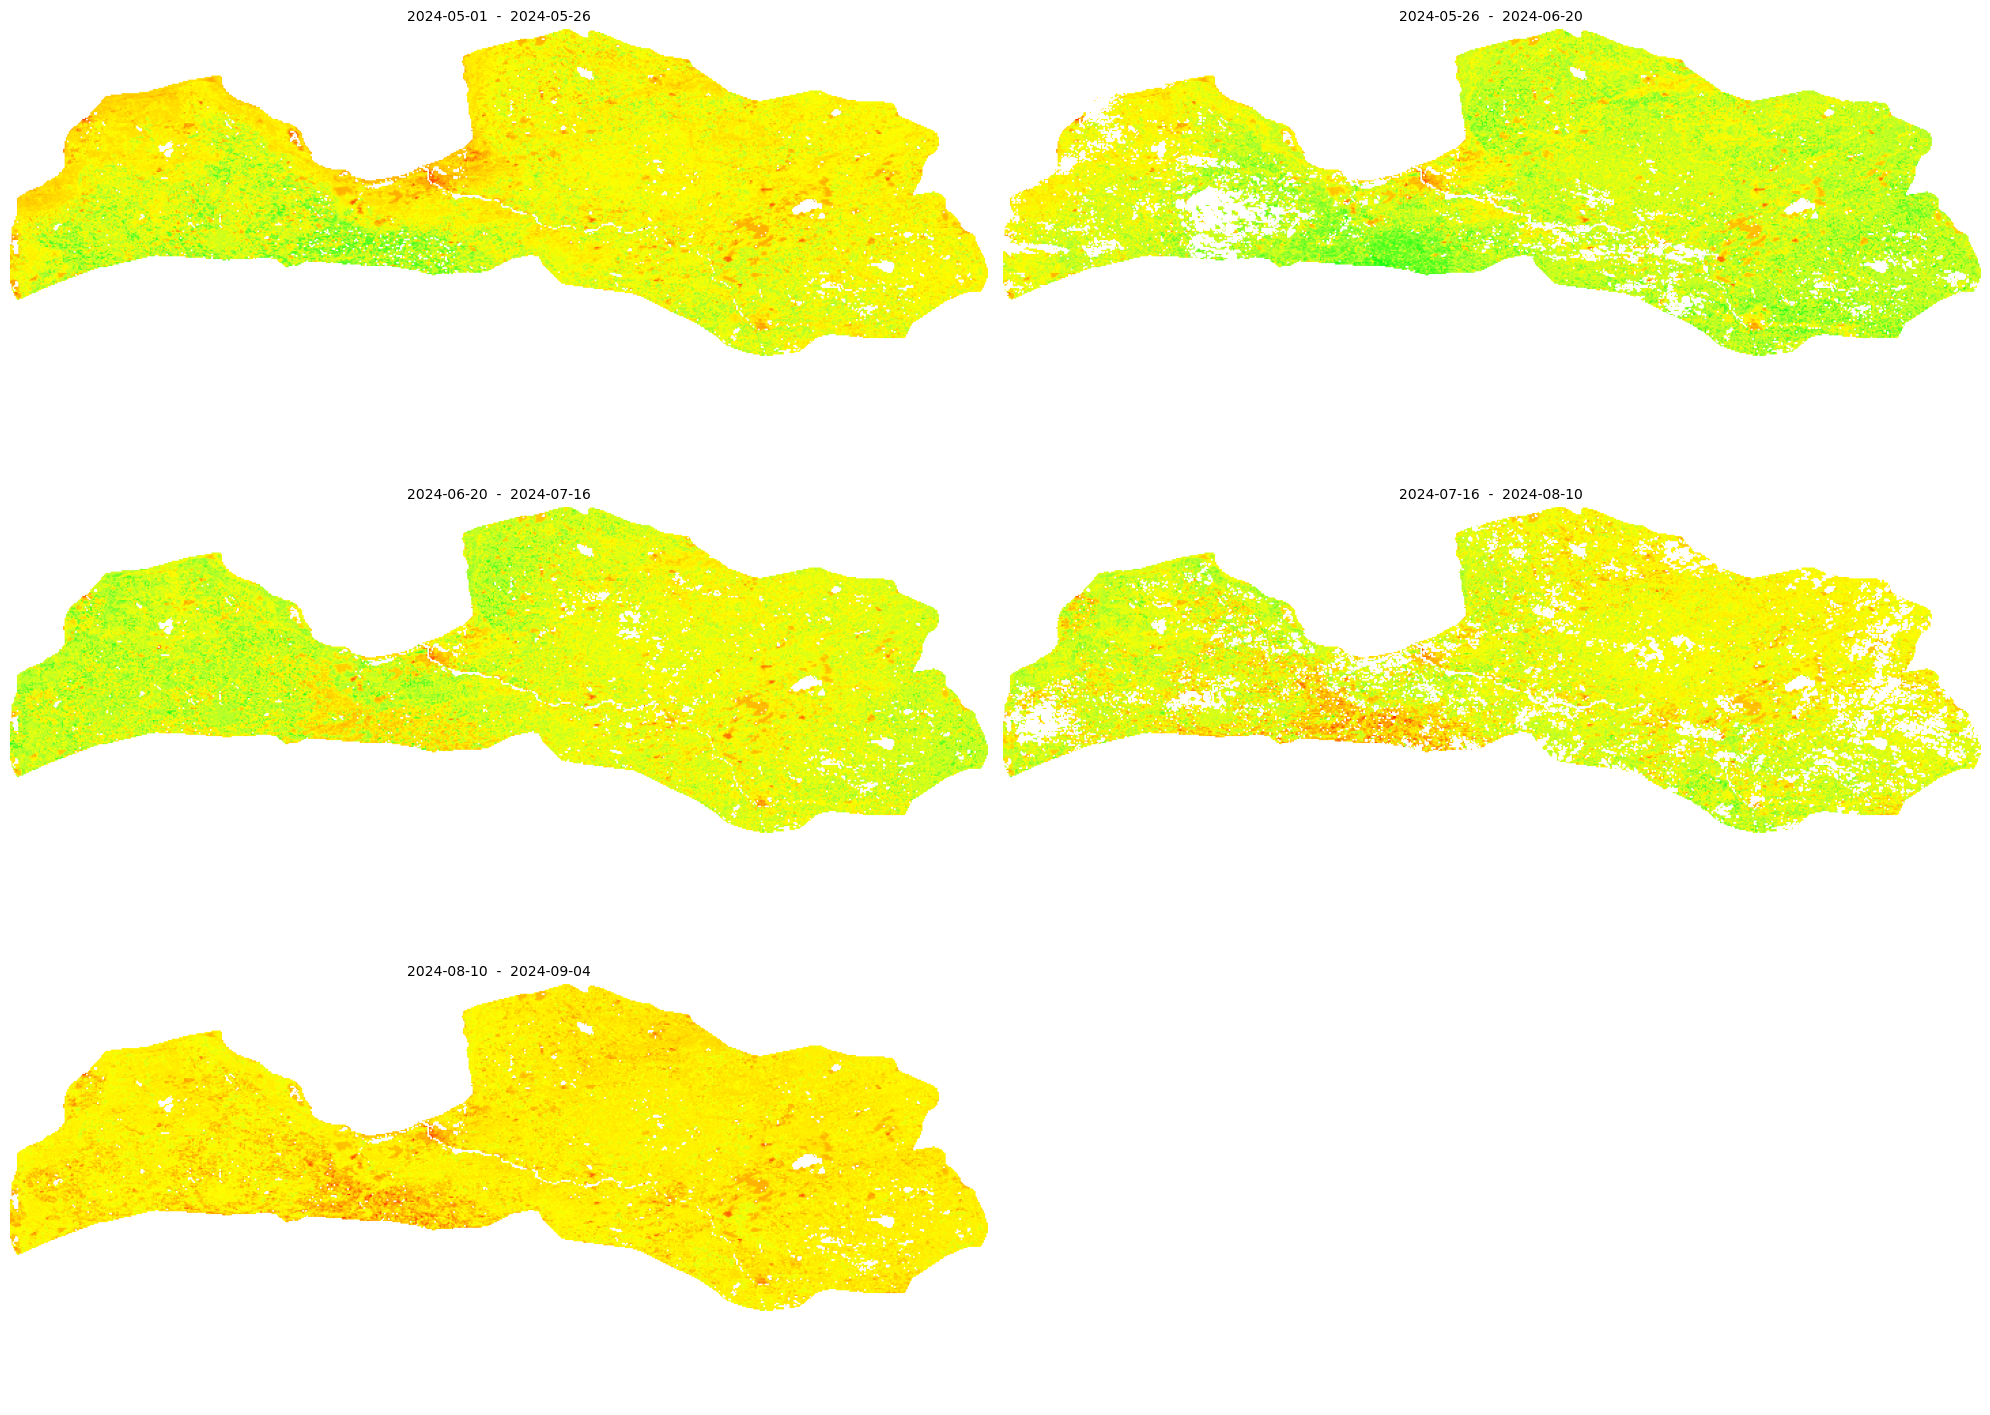

In [32]:
# some stuff for pretty plots
ncols = 2
nrows = 3
aspect_ratio = 1 / 0.5
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

In [38]:
forest_type_evalscript = """
//VERSION=3
const factor = 1;
const offset = 0;

function setup() {
  return {
    input: ["Forest_Type", "dataMask"],
    output: [
      { id: "default", bands: 4, sampleType: "UINT8" },
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "eobrowserStats", bands: 2, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ],
  };
}

function evaluatePixel(samples) {
  var originalValue = samples.Forest_Type;

  let val = originalValue * factor + offset;

  let dataMask = samples.dataMask;

  const indexVal = dataMask === 1 ? val : NaN;
  const imgVals = getColor(originalValue);

  return {
    default: imgVals.concat(dataMask * 255),
    index: [indexVal],
    eobrowserStats: [val, dataMask],
    dataMask: [dataMask],
  };
}

// LOOKUP TABLE FOR COLOURS, TO BE ADAPTED
const exactColorMap = [
  [0, [40, 40, 40]],
  [1, [102, 96, 0]],
  [2, [0, 153, 0]],
  [3, [112, 102, 62]],
  [4, [160, 220, 0]],
  [5, [146, 153, 0]],
];

// Function to fetch color for a given value
function getColor(value) {
  const entry = exactColorMap.find(([v, _]) => v === Math.floor(value));
  if (entry) {
    const [_, color] = entry;
    return [color[0], color[1], color[2]];
  } else {
    return [0, 0, 0];
  }
}
"""

In [39]:
# Create geometry for Latvia
geometry = Geometry(geometry=latvia_gdf.geometry.values[0], crs=CRS.WGS84)

# Create the request for forest type data
request = SentinelHubRequest(
    evalscript=forest_type_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(
                "35fecfec-8a73-4723-bb08-b775f283a535"
            ),
            time_interval=("2019-01-01", "2019-01-01"),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG),
    ],
    geometry=geometry,
    resolution=[0.01, 0.01],
    config=config,
)

print("Request created successfully. Fetching forest type data for Latvia...")

Request created successfully. Fetching forest type data for Latvia...


## Fetch and Visualize NPP Data

Let's fetch the NPP data and create a visualization showing the vegetation coverage across Latvia.

In [40]:
# Get the NPP data
npp_img = request.get_data()

print(f"Returned data is of type = {type(npp_img)} and length {len(npp_img)}.")
print(f"Single element in the list is of type {type(npp_img[0])} and has shape {npp_img[0].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (240, 719, 4)


Image type: uint8


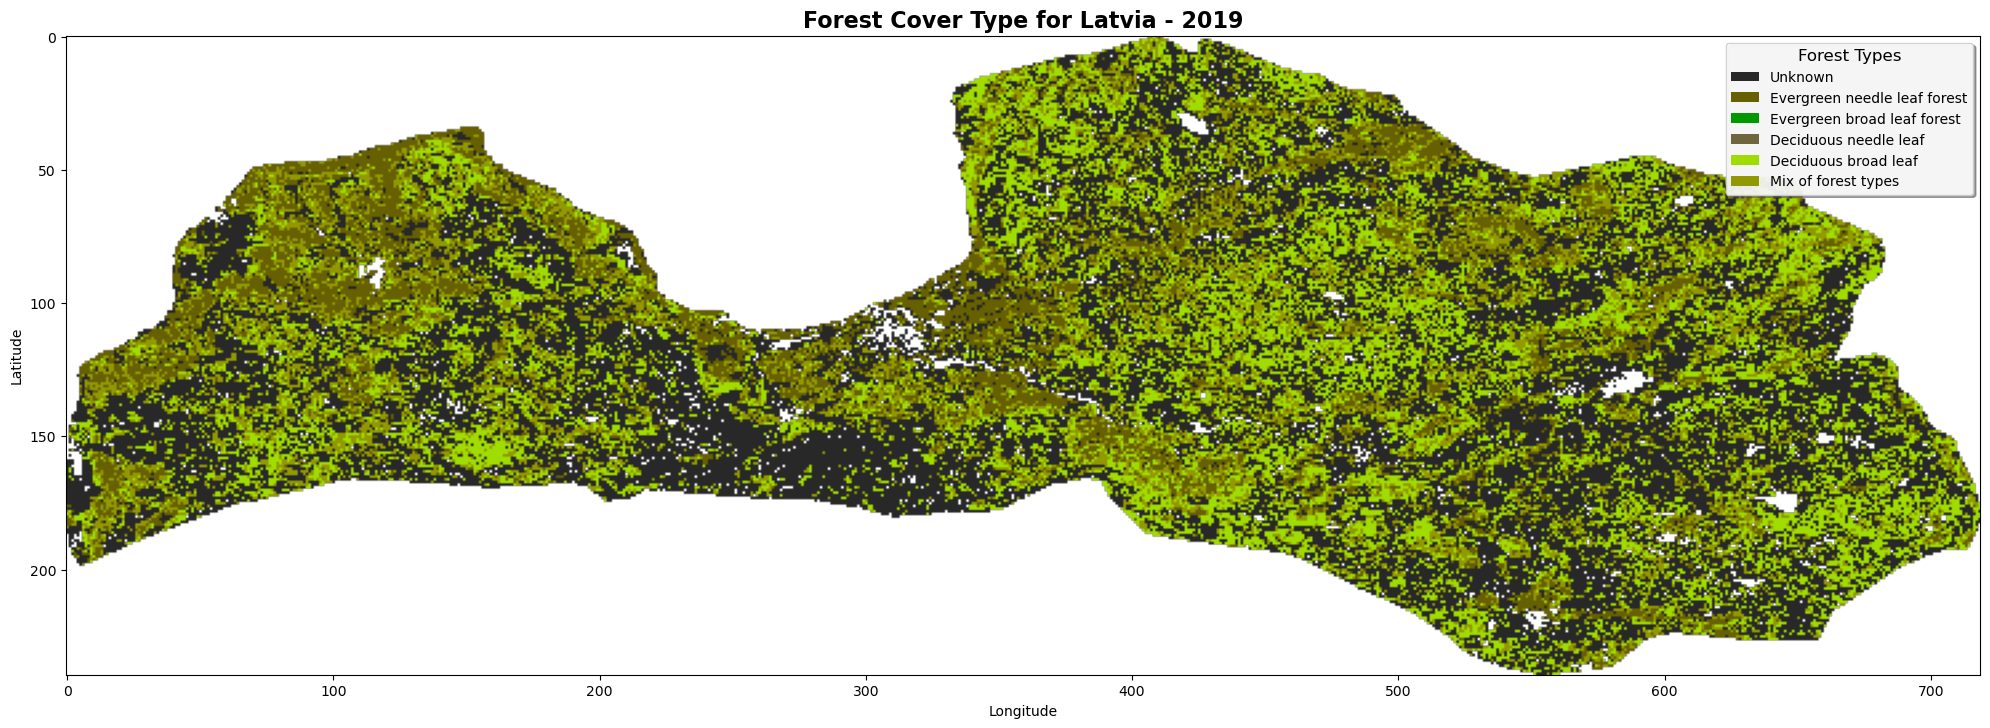

In [47]:
# Visualize the Forest Type data with integrated legend
image = npp_img[0]
print(f"Image type: {image.dtype}")

# Define the colormap and labels for the legend
forest_type_colors = {
    0: ([40, 40, 40], "Unknown"),
    1: ([102, 96, 0], "Evergreen needle leaf forest"),
    2: ([0, 153, 0], "Evergreen broad leaf forest"),
    3: ([112, 102, 62], "Deciduous needle leaf"),
    4: ([160, 220, 0], "Deciduous broad leaf"),
    5: ([146, 153, 0], "Mix of forest types")
}

# Create the visualization with legend integrated into the map
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Plot the main image
plt.imshow(image)
plt.title("Forest Cover Type for Latvia - 2019", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Create custom legend and place it on the map
from matplotlib.patches import Rectangle
legend_elements = []
for value, (color, label) in forest_type_colors.items():
    # Normalize color values from 0-255 to 0-1
    normalized_color = [c/255.0 for c in color]
    legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=normalized_color, label=label))

# Position the legend in the upper right corner of the map
legend = ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
                  title="Forest Types", title_fontsize=12, 
                  frameon=True, fancybox=True, shadow=True, 
                  framealpha=0.9, facecolor='white')

plt.tight_layout()
plt.show()

In [6]:
stat_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "Forest_Type",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: 1,
        sampleType: "UINT8"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    return {
        data: [samples.Forest_Type],
        dataMask: [samples.dataMask],
    };
}
"""

### The Statistical API Request Body

As this is a categorical dataset, we know the pixel values for each land cover class. This means we can use the histograms calculations parameter in our request. We can "bin" the data by each of the class codes. This will mean the output will include the count of pixels corresponding to each class.

Requesting histograms is optional. A variety of histogram customisations are available. Users can specify either of the following:
- arbitrary bins or
- width of bins `binWidth` or
- number of bins `nBins`.

Along with `binWidth` and `nBins` users can also provide values for `lowEdge` and/or `highEdge` parameters. Otherwise, their default values will be used, which correspond to min and max statistics for particular output band.
bbox = BBox(bbox=[8.379459, 47.298325, 8.715975, 47.480553], crs=CRS.WGS84)

In [33]:
calculations = {
    "default": {
        "histograms": {
            "default": {
                "bins": list(range(7))
            }
        }
    }
}

# Create geometry for Latvia
geometry = Geometry(geometry=latvia_gdf.geometry.values[0], crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=stat_evalscript,
        time_interval=('2019-01-01T00:00:00Z', '2019-01-02T23:59:59Z'),
        aggregation_interval='P1D',
        resolution=(0.01,0.01),        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.define_byoc('35fecfec-8a73-4723-bb08-b775f283a535'),                        
      ),
    ],
    geometry=geometry,
    calculations=calculations,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2019-01-01T00:00:00Z',
     'to': '2019-01-02T00:00:00Z'},
    'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.0,
         'max': 5.0,
         'mean': 2.050991166969023,
         'stDev': 2.158843915890586,
         'sampleCount': 172560,
         'noDataCount': 79387},
        'histogram': {'bins': [{'lowEdge': 0, 'highEdge': 1, 'count': 41334},
          {'lowEdge': 1, 'highEdge': 2, 'count': 11924},
          {'lowEdge': 2, 'highEdge': 3, 'count': 0},
          {'lowEdge': 3, 'highEdge': 4, 'count': 0},
          {'lowEdge': 4, 'highEdge': 5, 'count': 20402},
          {'lowEdge': 5, 'highEdge': 6, 'count': 19513}],
         'overflowCount': 0,
         'underflowCount': 0}}}}}}],
  'status': 'OK'}]

### Manipulation and Visualisation of our Output

We can now read the data in the output and convert the histogram data we need into a dictionary: 

In [34]:
# Extract the histogram data for band B0 from the response
b0_hist = response[0]['data'][0]["outputs"]["data"]["bands"]["B0"]["histogram"]["bins"]

# Extract the bin edges from the histogram data
res = {bin["lowEdge"]: bin["count"] for bin in b0_hist}



We can then open the dictionary into a pandas dataframe, and insert two columns in addition to the count. The class name and the color of each class based on the hex color code. Lastly, we can sort the values by the count so the most dominant land cover type is at the head of the dataframe.


In [35]:
# Printing resultant dictionary
print("Resultant dictionary is : " + str(res))
# Convert the dictionary to a DataFrame with the keys as the index
df = pd.DataFrame.from_dict(res, orient='index')

Resultant dictionary is : {0: 41334, 1: 11924, 2: 0, 3: 0, 4: 20402, 5: 19513}


In [ ]:
# Rename the first column to 'count'
df.rename(columns={0: 'count'}, inplace=True)

# Insert CLC class names and colors
df.insert(1, "Classname", ["Unknown", "Evergreen needle leaf forest", "Evergreen broad leaf forest", "Deciduous needle leaf", "Deciduous broad leaf", "Mix of forest types"], True)
df.insert(1, "Color", ["#282828", "#666000", "#009900", "#70663e", "#a0dc00", "#929900"], True)

# Sort the DataFrame by the 'count' column in descending order
df.sort_values(by=['count'], ascending=False, inplace=True)

# Filter the DataFrame to exclude rows where 'count' is 0
df_filtered = df[df['count'] != 0]

# Display the sorted DataFrame
df_filtered


count    Color                     Classname
0  41334  #282828                       Unknown
4  20402  #a0dc00          Deciduous broad leaf
5  19513  #929900           Mix of forest types
1  11924  #666000  Evergreen needle leaf forest

Before plotting the data we can filter the dataframe and remove all the classes that are not in the area of interest. We can then plot the waffle chart with the following code. Whilst there are several land cover classes, we can see the area of interest is dominated by three main land cover classes. Were you correct, when you guessed the most dominant land cover class from the map?


In [37]:
# Extract the 'count', 'Color', and 'Classname' columns as lists
count = df_filtered['count'].tolist()
color_ramp = df_filtered['Color'].tolist()
labels = df_filtered['Classname'].tolist()

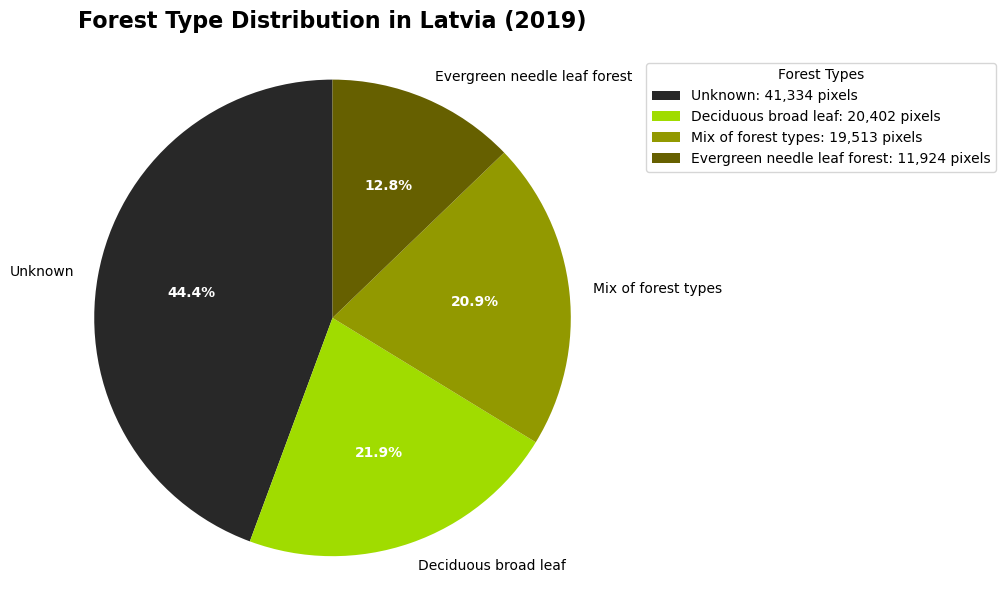

In [48]:
# Create a pie chart for forest type distribution in Latvia
plt.figure(figsize=(10, 6))

# Create the pie chart
wedges, texts, autotexts = plt.pie(count, labels=labels, colors=color_ramp, autopct='%1.1f%%', 
                                  startangle=90, textprops={'fontsize': 10})

# Enhance the appearance
plt.title('Forest Type Distribution in Latvia (2019)', fontsize=16, fontweight='bold', pad=20)

# Improve the percentage text readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Add a legend with counts
legend_labels = [f'{label}: {cnt:,} pixels' for label, cnt in zip(labels, count)]
plt.legend(wedges, legend_labels, title="Forest Types", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()